## Examining duplication Between Organisations

In our data we often recieve multiple data sources per dataset. unfortunately this leads to duplication of geometries and other data points in the datasets. this notebook looks to investigate identifying these duplications between organisations.

In [7]:
from download_data import download_dataset
from data import get_entity_dataset, nrow
from plot import plot_map, plot_issues_map
import spatialite
import pandas as pd
import geopandas as gpd
import os
import itertools
import shapely.wkt

import matplotlib.pyplot as plt
import time

import numpy as np

pd.set_option("display.max_rows", None)


download the sqlite3 file for the data. this will be used to run queries against

In [9]:
# download dataset
# dataset = 'article-4-direction-area'
# collection = 'article-4-direction-collection'
# data_dir = os.path.join('../data/entity_resolution',dataset)
# dataset_path = os.path.join(data_dir,f'{dataset}.sqlite3')

dataset = 'conservation-area'
collection = 'conservation-area-collection'
data_dir = os.path.join('../data/entity_resolution',dataset)
dataset_path = os.path.join(data_dir,f'{dataset}.sqlite3')

In [5]:
# download_dataset(dataset,collection,data_dir)

In [6]:
lookup_org = pd.read_csv("https://datasette.planning.data.gov.uk/digital-land.csv?sql=select%0D%0A++entity%2C%0D%0A++name%2C%0D%0A++organisation%2C%0D%0A++website%0D%0Afrom%0D%0A++organisation%0D%0Aorder+by%0D%0A++organisation%0D%0Alimit%0D%0A++1000&_size=max")

# reformat for joining
lookup_org["entity"] = lookup_org["entity"].astype(str)
lookup_org = lookup_org.iloc[:, 0:2]
lookup_org.columns = ["organisation_name", "organisation_name"]

nrow(lookup_org)
lookup_org.head()

No. of records in entity_df: 441


,organisation_entity,organisation_name
0,600003,Aycliffe and Peterlee Development Corporation
1,600004,Basildon Development Corporation
2,600007,Telford Development Corporation
3,1,Old Oak and Park Royal Development Corporation
4,600006,London Docklands Development Corporation


In [10]:
# load dataset into geopandas and transform CRS to EPSG:27700

entity_df = get_entity_dataset(dataset_path)
            
# entity_df.head()

# set entity to string, helpful for sorting and joining later
entity_df["entity"] = entity_df["entity"].astype(str)

# join organisation name
entity_df = entity_df.merge(
    lookup_org.iloc[:, 0:2], 
    how = "left")

# load geometry and create GDF
entity_df['geometry'] = entity_df['geometry'].apply(shapely.wkt.loads)
entity_gdf = gpd.GeoDataFrame(entity_df, geometry='geometry')

# Transform to ESPG:27700 for more interpretable area units
entity_gdf.set_crs(epsg=4326, inplace=True)
entity_gdf.to_crs(epsg=27700, inplace=True)

# calculate area
entity_gdf["area"] = entity_gdf["geometry"].area


nrow(entity_gdf)
entity_gdf.head()

No. of records in entity_df: 8,761


,entity,name,organisation_entity,reference,entry_date,start_date,geometry,organisation_name,area
0,44000001,Napsbury,16,5080,2022-04-12,1996-01-04,"MULTIPOLYGON (((516981.159 204270.242, 516973....",Historic England,495087.300218
1,44000002,Shafford Mill,16,5071,2022-04-12,1980-07-31,"MULTIPOLYGON (((512390.333 209659.962, 512382....",Historic England,136187.979619
2,44000003,Potters Crouch,16,5074,2022-04-12,1977-07-27,"MULTIPOLYGON (((511610.510 205098.079, 511611....",Historic England,34603.675292
3,44000004,Old Brickett Wood,16,5075,2022-04-12,1983-07-20,"MULTIPOLYGON (((512515.275 200300.431, 512520....",Historic England,55128.469061
4,44000005,Sleapshyde,16,5078,2022-04-12,1993-03-31,"MULTIPOLYGON (((520248.830 206717.191, 520410....",Historic England,44167.433073


# Identifying geographical duplicates

## #1 - Duplication within organisation

In [11]:
# Overlay all non-Heritage England entities
LPA_LPA_join = gpd.overlay(
    entity_gdf[entity_gdf["organisation_entity"] != "16"],
    entity_gdf[entity_gdf["organisation_entity"] != "16"],
    how = "intersection", keep_geom_type=False 
)

# remove entity self-intersections and intersections across organisations
LPA_LPA_join = LPA_LPA_join[(LPA_LPA_join["organisation_entity_1"] == LPA_LPA_join["organisation_entity_2"]) &
             (LPA_LPA_join["entity_1"] != LPA_LPA_join["entity_2"])]

# each intersection will be in there twice because we're joining the same dataset 
# (e.g. polygon1-polygon2 and polygon2-polygon1), so remove these
LPA_LPA_join["entity_join"] = LPA_LPA_join.apply(lambda x: '-'.join(sorted(x[["entity_1", "entity_2"]])), axis=1)
LPA_LPA_join.drop_duplicates(subset="entity_join", inplace = True) #Drop them by name

# calculate overlap %'s

LPA_LPA_join["area_intersection"] = LPA_LPA_join["geometry"].area

# LPA_LPA_join["p_pct_intersect"] = LPA_LPA_join["area_intersection"] / LPA_LPA_join["area_1"]
# LPA_LPA_join["pct_intersection"] = LPA_LPA_join["area_intersection"] / (LPA_LPA_join["area_1"] + LPA_LPA_join["area_2"] - LPA_LPA_join["area_intersection"])
# LPA_LPA_join["s_pct_intersect"] = LPA_LPA_join["area_intersection"] / LPA_LPA_join["area_2"]

# intersection area as % of smallest primary or secondary area
LPA_LPA_join["pct_min_intersection"] = LPA_LPA_join["area_intersection"] / LPA_LPA_join[["area_1", "area_2"]].min(axis = 1)

nrow(LPA_LPA_join)
LPA_LPA_join.head()

No. of records in entity_df: 557


,entity_1,name_1,organisation_entity_1,reference_1,entry_date_1,start_date_1,organisation_name_1,area_1,entity_2,name_2,organisation_entity_2,reference_2,entry_date_2,start_date_2,organisation_name_2,area_2,geometry,entity_join,area_intersection,pct_min_intersection
20,44000557,The Shaftesbury Conservation Area,222,21,2020-09-06,,North Dorset District Council,619417.315621,44000556,Second extension of the Shaftesbury Conservati...,222,20,2020-09-06,,North Dorset District Council,23007.353235,"MULTILINESTRING ((385730.973 122693.269, 38573...",44000556-44000557,0.000000,0.000000
23,44000558,Extension of the Shaftestbury Conservation Area,222,22,2020-09-06,,North Dorset District Council,159098.972628,44000557,The Shaftesbury Conservation Area,222,21,2020-09-06,,North Dorset District Council,619417.315621,GEOMETRYCOLLECTION (POLYGON ((385551.139 12291...,44000557-44000558,3.700185,0.000023
54,44004074,Landford Road Cons Area,376,COA00000876,2020-09-04,1978-06-13,London Borough of Wandsworth,170480.638459,44001043,Charlwood Road/Lifford Street Cons Area,376,COA00000831,2020-09-04,1970-01-01,London Borough of Wandsworth,101749.444224,GEOMETRYCOLLECTION (POLYGON ((523627.357 17554...,44001043-44004074,3.904702,0.000038
57,44004075,Putney Lower Common Cons Area,376,COA00000836,2020-09-04,1978-07-21,London Borough of Wandsworth,44247.655574,44004074,Landford Road Cons Area,376,COA00000876,2020-09-04,1978-06-13,London Borough of Wandsworth,170480.638459,GEOMETRYCOLLECTION (POLYGON ((522799.363 17559...,44004074-44004075,12.182724,0.000275
61,44004073,Westmead Cons Area,376,COA00000866,2020-09-04,1989-05-24,London Borough of Wandsworth,269082.414254,44001054,Roehampton Village Cons Area,376,COA00000826,2020-09-04,1969-07-29,London Borough of Wandsworth,72337.782467,GEOMETRYCOLLECTION (POLYGON ((522443.085 17387...,44001054-44004073,10.799050,0.000149


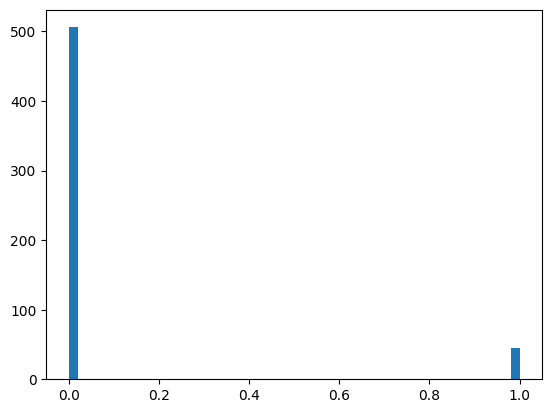

In [13]:
# quick check of distribution to check how many are edges vs. major overlaps
plt.hist(LPA_LPA_join["pct_min_intersection"], bins=50);

In [34]:
# how many entities with a greater than 10% intersection?
nrow(LPA_LPA_join[(LPA_LPA_join["pct_min_intersection"] > 0.1)])

LPA_LPA_join[(LPA_LPA_join["pct_min_intersection"] > 0.1)].sort_values("pct_min_intersection", ascending=False)

No. of records in entity_df: 49


,entity_1,name_1,organisation_entity_1,reference_1,entry_date_1,start_date_1,organisation_name_1,area_1,entity_2,name_2,organisation_entity_2,reference_2,entry_date_2,start_date_2,organisation_name_2,area_2,geometry,entity_join,area_intersection,pct_min_intersection
878,44007790,Southminster (Reduction3),206,40,2020-09-14,,Maldon District Council,2.158582e+03,44007829,Southminster,206,81,2020-09-14,,Maldon District Council,4.689974e+04,"POLYGON ((596084.390 199726.273, 596085.782 19...",44007790-44007829,2.158582e+03,1.000000
87,44008666,Church Street (Epsom),129,19,2020-09-06,,Epsom and Ewell Borough Council,1.057791e+05,44001971,"Church Street, Epsom",129,10/00009/CONARA,2023-11-15,2010-11-16,Epsom and Ewell Borough Council,1.057791e+05,"POLYGON ((521357.764 160752.122, 521368.481 16...",44001971-44008666,1.057791e+05,1.000000
899,44007800,Tollesbury (Reduction4),206,50,2020-09-14,,Maldon District Council,8.752348e+01,44007822,Tollesbury,206,73,2020-09-14,,Maldon District Council,8.409591e+04,"POLYGON ((595578.545 210492.760, 595577.464 21...",44007800-44007822,8.752348e+01,1.000000
796,44007827,Heybridge Basin,206,79,2020-09-14,,Maldon District Council,4.730912e+04,44007764,Heybridge Basin (Reduction1),206,14,2020-09-14,,Maldon District Council,3.374597e+02,"POLYGON ((587128.532 207052.797, 587131.120 20...",44007764-44007827,3.374597e+02,1.000000
766,44007808,Maldon (Reduction1),206,58,2020-09-14,,Maldon District Council,1.383356e+03,44007830,Maldon (1),206,82,2020-09-14,,Maldon District Council,1.909504e+05,"POLYGON ((585117.755 207462.320, 585108.767 20...",44007808-44007830,1.383356e+03,1.000000
1198,44008224,"Market Street, Stourbridge",113,81,2021-11-25,,Dudley Metropolitan Borough Council,9.181689e+02,44008223,HIGH STREET STOUBRIDGE.,113,71,2021-11-25,,Dudley Metropolitan Borough Council,6.262320e+04,"POLYGON ((390034.850 284270.471, 390040.829 28...",44008223-44008224,9.181689e+02,1.000000
99,44008661,Ewell Village (Seymour Mews),129,10,2020-09-06,,Epsom and Ewell Borough Council,3.241712e+03,44001790,Ewell Village,129,000008/CONARA,2023-11-15,2009-06-30,Epsom and Ewell Borough Council,7.276274e+05,"POLYGON ((522204.788 162297.189, 522231.590 16...",44001790-44008661,3.241712e+03,1.000000
1191,44008239,THE VILLAGE KINGSWINFORD,113,90,2021-11-25,,Dudley Metropolitan Borough Council,3.969382e+04,44008219,THE PADDOCK 66 HIGH STREET KINGSWINFORD.,113,77,2021-11-25,,Dudley Metropolitan Borough Council,8.380729e+02,"POLYGON ((389340.103 289211.437, 389346.884 28...",44008219-44008239,8.380729e+02,1.000000
894,44007795,Tollesbury (Reduction1),206,45,2020-09-14,,Maldon District Council,5.891218e+02,44007822,Tollesbury,206,73,2020-09-14,,Maldon District Council,8.409591e+04,"POLYGON ((595733.833 210517.392, 595734.800 21...",44007795-44007822,5.891218e+02,1.000000
879,44007791,Southminster (Reduction4),206,41,2020-09-14,,Maldon District Council,1.084394e+02,44007829,Southminster,206,81,2020-09-14,,Maldon District Council,4.689974e+04,"POLYGON ((595875.630 199744.900, 595871.866 19...",44007791-44007829,1.084394e+02,1.000000


In [14]:
LPA_LPA_join[(LPA_LPA_join["pct_min_intersection"] > 0.1)].groupby(["organisation_name_1"]).size().sort_values(ascending = False)

organisation_name_1
Maldon District Council                   20
London Borough of Lambeth                  8
Epsom and Ewell Borough Council            7
London Borough of Hammersmith & Fulham     4
London Borough of Southwark                4
Sheffield City Council                     3
Dudley Metropolitan Borough Council        2
Buckinghamshire Council                    1
dtype: int64

**notes from run through with Swati**

solution - go back to LPA
possible explanation - data is coming from different endpoint, and first one is not retired. Need to rule this out before we go back to LPA.

When new endpoint is added, we want to keep both. Want to keep record of data over time. Platform should only present latest version.
Need to understand entity creation process a little bit more to understand how geo duplicates could get made - talk to Kena.

In [16]:
# inspect example
plot_issues_map(entity_gdf, ["44008830", "44006848"], "entity", "Accent")


In [18]:
plot_issues_map(entity_gdf, ["44007790", "44007829"], "entity", "Accent")
# inspect_issues_map(entity_gdf, ["44000557", "44000556"], "Accent")


## #2 - Intersection across different LPAs

In [19]:
# Overlay all non-Heritage England entities
LPA_cross_join = gpd.overlay(
    entity_gdf[entity_gdf["organisation_entity"] != "16"],
    entity_gdf[entity_gdf["organisation_entity"] != "16"],
    how = "intersection", keep_geom_type=False 
)

# filter to join across organisations and entities
LPA_cross_join = LPA_cross_join[(LPA_cross_join["organisation_entity_1"] != LPA_cross_join["organisation_entity_2"]) &
             (LPA_cross_join["entity_1"] != LPA_cross_join["entity_2"])]

# each intersection will be in there twice because we're joining the same dataset 
# (e.g. polygon1-polygon2 and polygon2-polygon1), so remove these
LPA_cross_join["entity_join"] = LPA_cross_join.apply(lambda x: '-'.join(sorted(x[["entity_1", "entity_2"]])), axis=1)
LPA_cross_join.drop_duplicates(subset="entity_join", inplace = True) #Drop them by name

# # calculate overlap %'s

LPA_cross_join["area_intersection"] = LPA_cross_join["geometry"].area

# # LPA_LPA_join["p_pct_intersect"] = LPA_LPA_join["area_intersection"] / LPA_LPA_join["area_1"]
# # LPA_LPA_join["pct_intersection"] = LPA_LPA_join["area_intersection"] / (LPA_LPA_join["area_1"] + LPA_LPA_join["area_2"] - LPA_LPA_join["area_intersection"])
# # LPA_LPA_join["s_pct_intersect"] = LPA_LPA_join["area_intersection"] / LPA_LPA_join["area_2"]

# intersection area as % of smallest primary or secondary area
LPA_cross_join["pct_min_intersection"] = LPA_cross_join["area_intersection"] / LPA_cross_join[["area_1", "area_2"]].min(axis = 1)

nrow(LPA_cross_join)
LPA_cross_join.head()

No. of records in entity_df: 46


,entity_1,name_1,organisation_entity_1,reference_1,entry_date_1,start_date_1,organisation_name_1,area_1,entity_2,name_2,organisation_entity_2,reference_2,entry_date_2,start_date_2,organisation_name_2,area_2,geometry,entity_join,area_intersection,pct_min_intersection
67,44008941,Thames,182,COA00000544,2020-09-04,,Royal Borough of Kensington and Chelsea,306674.786572,44001064,Battersea Square Cons Area,376,COA00000338,2020-09-04,1972-11-09,London Borough of Wandsworth,1.234642e+05,"POLYGON ((526643.359 176971.706, 526643.284 17...",44001064-44008941,0.006540,5.296789e-08
175,44008828,Walcot,192,COA00000224,2020-09-04,,London Borough of Lambeth,80645.499631,44002361,West Square,329,14,2023-08-16,1971-09-17,London Borough of Southwark,1.567235e+05,"MULTIPOLYGON (((531397.460 178999.938, 531451....",44002361-44008828,61.364033,7.609108e-04
181,44008827,St Marks,192,COA00000222,2020-09-04,,London Borough of Lambeth,258058.687895,44002362,Kennington Park Road,329,9,2023-08-16,1968-09-27,London Borough of Southwark,3.449127e+04,"POLYGON ((531567.046 177878.773, 531566.975 17...",44002362-44008827,1.594233,4.622134e-05
216,44008587,Minet Estate,192,CA25,2022-01-19,,London Borough of Lambeth,254651.578819,44002371,Camberwell New Road,329,5,2023-08-16,1968-09-27,London Borough of Southwark,8.611913e+04,"POLYGON ((532016.682 176737.603, 532035.491 17...",44002371-44008587,287.899188,3.343034e-03
235,44008841,0,198,COA00000275,2020-09-04,,London Borough of Lewisham,61970.455240,44002380,Dulwich Wood,329,24,2023-08-16,1985-09-30,London Borough of Southwark,1.806972e+06,"MULTIPOLYGON (((534602.962 172572.973, 534608....",44002380-44008841,731.761008,1.180822e-02


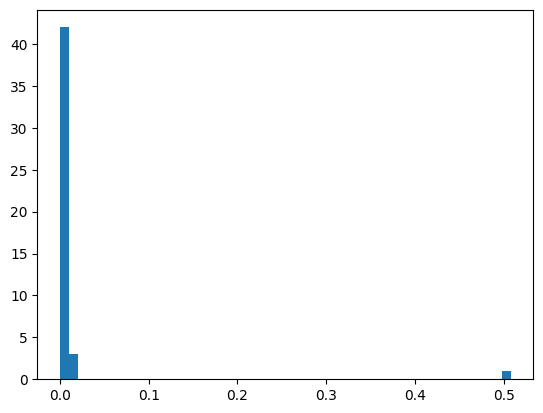

In [20]:
# Look at distribution to check how many are edges vs. major overlaps
plt.hist(LPA_cross_join["pct_min_intersection"], bins=50);

In [22]:
# how many entities which have issues of intersection > 10%? 
LPA_cross_join[(LPA_cross_join["pct_min_intersection"] > 0.1)]

,entity_1,name_1,organisation_entity_1,reference_1,entry_date_1,start_date_1,organisation_name_1,area_1,entity_2,name_2,organisation_entity_2,reference_2,entry_date_2,start_date_2,organisation_name_2,area_2,geometry,entity_join,area_intersection,pct_min_intersection
676,44009059,,329,COA00000781,2020-09-04,,London Borough of Southwark,18976.083189,44008830,South Bank,192,COA00000240,2020-09-04,,London Borough of Lambeth,536689.574671,"POLYGON ((531348.617 180459.492, 531276.469 18...",44008830-44009059,9639.44694,0.507979


In [53]:
e = "44009059"
ents = LPA_cross_join[(LPA_cross_join["entity_1"] == e)][["entity_1", "entity_2"]].iloc[0, :].values

plot_issues_map(entity_gdf, ents, "organisation_name", "Accent")

**notes from run-through with Swati**   
feed in LPA boundaries here to make sure we contact the right LPA - change this query to use LPA boundaries.
check with Carlos for how it's been done for brownfield

## Issue #3 LPA => Historic England intersections

In [26]:
# start_time = time.time()

LPA_HE_join = gpd.overlay(
    entity_gdf[entity_gdf["organisation_entity"] != "16"],
    entity_gdf[entity_gdf["organisation_entity"] == "16"],
    how = "intersection", keep_geom_type=False
)

LPA_HE_join["area_intersection"] = LPA_HE_join["geometry"].area

LPA_HE_join["p_pct_intersect"] = LPA_HE_join["area_intersection"] / LPA_HE_join["area_1"]
LPA_HE_join["pct_intersection"] = LPA_HE_join["area_intersection"] / (LPA_HE_join["area_1"] + LPA_HE_join["area_2"] - LPA_HE_join["area_intersection"])
LPA_HE_join["s_pct_intersect"] = LPA_HE_join["area_intersection"] / LPA_HE_join["area_2"]


# intersection area as % of smallest primary or secondary area
LPA_HE_join["pct_min_intersection"] = LPA_HE_join["area_intersection"] / LPA_HE_join[["area_1", "area_2"]].min(axis = 1)


# end_time = time.time()

# elapsed_time = (end_time - start_time) 
# print(f"Elapsed time: {elapsed_time:.2f} ")

nrow(LPA_HE_join)
LPA_HE_join.head()

No. of records in entity_df: 793


,entity_1,name_1,organisation_entity_1,reference_1,entry_date_1,start_date_1,organisation_name_1,area_1,entity_2,name_2,...,entry_date_2,start_date_2,organisation_name_2,area_2,geometry,area_intersection,p_pct_intersect,pct_intersection,s_pct_intersect,pct_min_intersection
0,44000540,The Hinton St Mary Conservation Area,222,45,2020-09-06,,North Dorset District Council,271632.834883,44002322,,...,2022-04-12,,Historic England,6.092177e+08,"POLYGON ((378317.034 116323.476, 378314.048 11...",271632.834883,1.0,0.000446,0.000446,1.0
1,44000549,The Farnham Conservation Area,222,13,2020-09-06,,North Dorset District Council,248447.273755,44002322,,...,2022-04-12,,Historic England,6.092177e+08,"POLYGON ((395687.904 115525.150, 395887.261 11...",248447.273755,1.0,0.000408,0.000408,1.0
2,44000551,Stourton Caundle Conservation Area,222,15,2020-09-06,,North Dorset District Council,107920.554378,44002322,,...,2022-04-12,,Historic England,6.092177e+08,"POLYGON ((371523.221 114654.328, 371519.930 11...",107920.554378,1.0,0.000177,0.000177,1.0
3,44000552,The Charlton Marshall Conservation Area,222,16,2020-09-06,,North Dorset District Council,143088.444037,44002322,,...,2022-04-12,,Historic England,6.092177e+08,"POLYGON ((389787.452 104398.843, 389895.392 10...",143088.444037,1.0,0.000235,0.000235,1.0
4,44000553,The Stour Provost Conservation Area,222,17,2020-09-06,,North Dorset District Council,138300.397606,44002322,,...,2022-04-12,,Historic England,6.092177e+08,"POLYGON ((379351.667 121384.347, 379350.181 12...",138300.397606,1.0,0.000227,0.000227,1.0


Text(0, 0.5, '% of Historic England entity intersected')

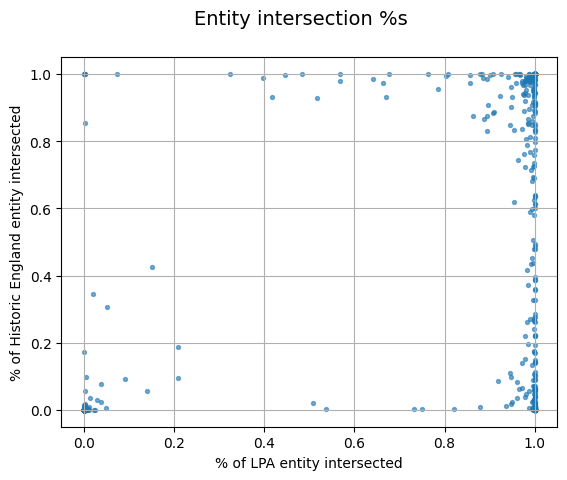

In [41]:
# plot the issues by the amount the two entities which make up each issue intersect each other
# this is useful to start to define categories for the types of issues they represent

fig = plt.figure()
plt.grid()
plt.scatter(LPA_HE_join["p_pct_intersect"], LPA_HE_join["s_pct_intersect"], s = 8, alpha=0.6)
fig.suptitle('Entity intersection %s', fontsize=14)
plt.xlabel('% of LPA entity intersected', fontsize=10)
plt.ylabel('% of Historic England entity intersected', fontsize=10)

By the number of points on the far right of the chart we can see that there are a lot of LPA entities which are entirely or almost entirely contained within an HE entity, but how closely the HE area matches varies from not at all to almost exactly.

Bottom left is a cluster of tiny edge intersections, and there are a small number of instances where HE entities are contained within LPA ones.

In [43]:
# flag issue types - defined to pick up main issue clusters on chart above and using a 90% or 10% intersection cutoffs

LPA_HE_join["issue_type"] = np.select(
    [
        (LPA_HE_join["p_pct_intersect"] >= 0.9) & (LPA_HE_join["s_pct_intersect"] >= 0.9),
        (LPA_HE_join["p_pct_intersect"] <= 0.1) & (LPA_HE_join["s_pct_intersect"] <= 0.1),
        (LPA_HE_join["p_pct_intersect"] >= 0.9),
        (LPA_HE_join["s_pct_intersect"] >= 0.9)
    ],
    [
        "LPA and HE cover each other", "edge intersection", "LPA covered by HE", "LPA covers HE"
    ],
    default = "-"
)

In [161]:
# LPA_HE_join[(LPA_HE_join["pct_intersection"] >= 0.9)].sort_values("pct_intersection")
# LPA_HE_join[(LPA_HE_join["issue_type"] == "LPA covers HE")].sort_values("pct_intersection")

In [45]:
# count of issue types (where cover is defined as >=90% intersection, and edge as <=10%)
LPA_HE_join.groupby(["issue_type"]).size()

issue_type
-                               18
LPA and HE cover each other    173
LPA covered by HE              201
LPA covers HE                   28
edge intersection              373
dtype: int64

In [46]:
# LPAs with most non-intersection issues
LPA_HE_join[(LPA_HE_join["issue_type"] != "edge intersection")].groupby(["organisation_name_1"]).size().sort_values(ascending = False).head(15)

organisation_name_1
Maldon District Council                   60
North Dorset District Council             37
London Borough of Bromley                 37
Medway Council                            24
Great Yarmouth Borough Council            21
Peak District National Park Authority     19
Sheffield City Council                    15
Gloucester City Council                   14
London Borough of Hounslow                14
Waverley Borough Council                  13
London Borough of Bexley                  12
Mole Valley District Council              12
London Borough of Richmond upon Thames    12
East Suffolk Council                      11
London Borough of Hillingdon              10
dtype: int64

### Issue examples by type

#### LPA and HE cover each other (almost perfect matches)

- need to get to the bottom of authority here, who can create conservation areas
- could we just switch off HE conservation areas 

In [54]:
e = "44008960"
ents = LPA_HE_join[(LPA_HE_join["entity_1"] == e)][["entity_1", "entity_2"]].iloc[0, :].values

plot_issues_map(entity_gdf, ents, "organisation_name", "Accent")


#### LPA covered by HE

In [55]:
e = "44000540"
ents = LPA_HE_join[(LPA_HE_join["entity_1"] == e)][["entity_1", "entity_2"]].iloc[0, :].values

plot_issues_map(entity_gdf, ents, "organisation_name", "Accent")


#### LPA covers HE

In [56]:
e = "44009160"
ents = LPA_HE_join[(LPA_HE_join["entity_1"] == e)][["entity_1", "entity_2"]].iloc[0, :].values

plot_issues_map(entity_gdf, ents, "organisation_name", "Accent")

#### Edge intersection

In [57]:
e = "44006512"
ents = LPA_HE_join[(LPA_HE_join["entity_1"] == e)][["entity_1", "entity_2"]].iloc[0, :].values

plot_issues_map(entity_gdf, ents, "organisation_name", "Accent")

#### Entities with multiple issues

In [107]:
# LPA_HE_join[(LPA_HE_join["entity_1"] == "44006512")]

entity_count = LPA_HE_join.groupby(["entity_1"]).size().reset_index()
entity_count.columns = ["entity_1", "count"]
entity_count[entity_count["count"] > 1].sort_values('count', ascending = False)

,entity_1,count
425,44009090,8
473,44009667,8
82,44006848,7
396,44009057,7
314,44008830,7
432,44009107,6
486,44009680,5
347,44008936,5
482,44009676,5
59,44005248,5


In [58]:
t = LPA_HE_join[LPA_HE_join["entity_1"] == "44009667"]

# grab all entities that have an issue with  44009667
te = np.concatenate((
    t["entity_1"].drop_duplicates().values,
    t["entity_2"].drop_duplicates().values
))

plot_issues_map(entity_gdf, te, "organisation_name", "Accent")


#### Entities with non-classified issues

In [59]:
# these are really just entities which have overlaps > 10% but less than 90% in one form 
LPA_HE_join[(LPA_HE_join["issue_type"] == "-")].sort_values("pct_min_intersection", ascending = False)

,entity_1,name_1,organisation_entity_1,reference_1,entry_date_1,start_date_1,organisation_name_1,area_1,entity_2,name_2,...,start_date_2,organisation_name_2,area_2,geometry,area_intersection,p_pct_intersect,pct_intersection,s_pct_intersect,pct_min_intersection,issue_type
297,44007829,Southminster,206,81,2020-09-14,,Maldon District Council,4.689974e+04,44004490,Southminster,...,1979-02-26,Historic England,5.058812e+04,"POLYGON ((595755.431 199801.486, 595807.643 19...",41932.862412,0.894096,0.754799,0.828907,0.894096,-
421,44008747,,65,COA00000061,2020-09-04,,London Borough of Bromley,1.486251e+04,44002832,"Broomhill, Orpington",...,1989-01-01,Historic England,1.516235e+04,"POLYGON ((546239.633 166625.492, 546234.787 16...",13279.926213,0.893519,0.793072,0.875849,0.893519,-
489,44008891,,261,COA00000398,2020-09-04,,London Borough of Redbridge,1.782266e+05,44000597,Woodford Bridge,...,1970-01-01,Historic England,1.828150e+05,"POLYGON ((542546.930 191948.477, 542546.876 19...",158363.470238,0.888551,0.781355,0.866250,0.888551,-
466,44009032,,65,COA00000740,2020-09-04,,London Borough of Bromley,5.103176e+03,44007230,"Bromley, Hayes and Keston Commons",...,2000-01-01,Historic England,6.041063e+05,"POLYGON ((542234.754 165787.208, 542193.012 16...",4483.432772,0.878557,0.007414,0.007422,0.878557,-
490,44008901,,43,COA00000413,2020-09-04,,London Borough of Bexley,1.543272e+04,44002791,Brook Street,...,1992-02-19,Historic England,1.523364e+04,"POLYGON ((549779.678 177570.081, 549760.080 17...",13314.934676,0.862773,0.767368,0.874048,0.874048,-
618,44009107,Chichester Harbour,80,1,2020-09-05,,Chichester District Council,5.981653e+07,44004217,Fishbourne,...,1981-01-01,Historic England,1.636014e+05,"POLYGON ((484375.452 104491.567, 484378.496 10...",139614.101807,0.002334,0.002333,0.853380,0.853380,-
472,44009038,,65,COA00000747,2020-09-04,,London Borough of Bromley,1.082396e+03,44007230,"Bromley, Hayes and Keston Commons",...,2000-01-01,Historic England,6.041063e+05,"POLYGON ((542033.825 164908.595, 542031.258 16...",888.415933,0.820786,0.001470,0.001471,0.820786,-
462,44009024,,65,COA00000735,2020-09-04,,London Borough of Bromley,1.283744e+03,44007230,"Bromley, Hayes and Keston Commons",...,2000-01-01,Historic England,6.041063e+05,"POLYGON ((540421.804 165571.920, 540415.056 16...",961.569895,0.749036,0.001591,0.001592,0.749036,-
463,44009029,,65,COA00000737,2020-09-04,,London Borough of Bromley,2.277625e+03,44007230,"Bromley, Hayes and Keston Commons",...,2000-01-01,Historic England,6.041063e+05,"POLYGON ((540027.349 165869.822, 540008.914 16...",1666.551826,0.731706,0.002756,0.002759,0.731706,-
262,44007773,Langford (Addition2),206,23,2020-09-14,,Maldon District Council,2.365143e+04,44001675,Chelmer and Blackwater Navigation,...,1991-11-20,Historic England,5.103097e+06,"POLYGON ((583972.236 208922.549, 583973.403 20...",12708.386938,0.537320,0.002485,0.002490,0.537320,-


## Questions to resolve
* how to find endpoint / resource for each entity?
* what existing issues / replacements have been documented for the dataset?
* which entity takes precedence? Oldest / newest?
* what threshold to set for removing duplicates?
* how to extract data required for updating through lookups file
* how to replicate this check in endpoint checker with a new dataset